# Linear Regression Modeling of King County Real Estate Sale Prices
<b>Authors:</b> Aisha Baitemirova-Othman, Angela Kim, Steven Addison, Wahaj Dar
\
<b>Instructor:</b> David Elliott
----

## Overview
This project analyzes King County residential real estate in Washington state.

## Business Problem
Windermere Real Estate

## Data Understanding
This dataset contains information about residential real estate in King County between May 2014 - May 2015. It includes details such as number of bedrooms and bathrooms, square footage of the home, and various features regarding location.

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

!pip install geopy
import geopy
from geopy import distance

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt

| Here we import our data and skim the first five rows to get a general idea of what the dataframe looks like. We also get an initial look at missing values and datatypes that need to be converted.

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
display(df.head())
display(df.info())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

None

| Cleaning & preparing the data.

In [3]:
# Drop the 'id' and 'date' columns
# Fill in missing data
# Convert all object datatype columns to numeric

df.drop(labels=['id', 'date'], axis=1, inplace=True)
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['waterfront'] = df['waterfront'].fillna('NO')
df['waterfront'] = df['waterfront'].str.replace('NO', '0')
df['waterfront'] = df['waterfront'].str.replace('YES', '1')
df['waterfront'] = pd.to_numeric(df['waterfront'])
df['view'] = df['view'].fillna('NONE')
df['grade'] = df['grade'].str.replace('7 Average', '7')
df['grade'] = df['grade'].str.replace('8 Good', '8')
df['grade'] = df['grade'].str.replace('9 Better', '9')
df['grade'] = df['grade'].str.replace('6 Low Average', '6')
df['grade'] = df['grade'].str.replace('10 Very Good', '10')
df['grade'] = df['grade'].str.replace('11 Excellent', '11')
df['grade'] = df['grade'].str.replace('5 Fair', '5')
df['grade'] = df['grade'].str.replace('12 Luxury', '12')
df['grade'] = df['grade'].str.replace('4 Low', '4')
df['grade'] = df['grade'].str.replace('13 Mansion', '13')
df['grade'] = df['grade'].str.replace('3 Poor', '3')
df['grade'] = pd.to_numeric(df['grade'])
if [df[df['sqft_basement'] == '?']]:
    df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])
df['bedrooms'].replace(33, 3, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['yr_sold'] = df['date'].dt.year
df['house_age'] = df['yr_sold'] - df['yr_built']

In [ ]:
# Look at correlations

corr = df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='RdBu', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

In [4]:
# One-hot encoding 'condition' and 'view' columns

condition = df[['condition']]
ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")
ohe.fit(condition)
condition_enc = ohe.transform(condition)
condition_enc = pd.DataFrame(condition_enc,
                             columns=['cond_avg','cond_fair','cond_good','cond_poor','cond_verygood'],
                             index=df.index)
df.drop('condition', axis=1, inplace=True)
df = pd.concat([df, condition_enc], axis=1)

view = df[['view']]
ohe.fit(view)
view_enc = ohe.transform(view)
view_enc = pd.DataFrame(view_enc,
                        columns=['view_avg','view_excellent','view_fair','view_good','view_none'],
                        index=df.index)
df.drop('view', axis=1, inplace=True)
df = pd.concat([df, view_enc], axis=1)

In [5]:
# Create 'distance_from_bellevue' column

bellevue = (47.601, -122.2015)

def distancer(row):
    coords_1 = bellevue
    coords_2 = (row['lat'], row['long'])
    return geopy.distance.distance(coords_1, coords_2).miles

df['distance_from_bellevue'] = df.apply(distancer, axis=1)

| 'sqft_living' has the highest correlation with 'price' at 0.70. We also see high multicollinearity.

In [ ]:
# Scatter matrix

scatter_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                   'floors', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',
                   'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15','sqft_lot15']

df_scatter = df[scatter_columns]

sns.pairplot(df_scatter, corner=True);

| Scatter matrix shows many non-normal distributions.

## Inferential Modeling

In [7]:
# Analyzing OLS results

outcome = 'price'
df2 = df.drop('price', axis=1)
predictors = '+'.join(df2.columns)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     2347.
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:05:42   Log-Likelihood:            -2.9353e+05
No. Observations:               21597   AIC:                         5.871e+05
Df Residuals:                   21572   BIC:                         5.873e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.514e+07   2.04e+06      7.435      0.000    1.11e+07    1.91e+07
bedrooms               -4.068e+04   1904.839    -21.358      0.000   -4.44e+04    -3.7e+04
bathrooms               4.026e+04   3147.640     12.792      0.000    3.41e+04    4.64e+04
sqft_living              111.3085      2.200     50.590      0.000     106.996     115.621
sqft_lot                   0.2176      0.046      4.713      0.000       0.127       0.308
floors                  1757.8408   3472.384      0.506      0.613   -5048.288    8563.970
waterfront              5.345e+05   1.96e+04     27.258      0.000    4.96e+05    5.73e+05
grade                    8.82e+04   2092.880     42.141      0.000    8.41e+04    9.23e+04
sqft_above                78.4137      2.177     36.023      0.000      74.147      82.680
sqft_basement             32.9183      2.555     12.885      0.000      27.911      37.926
yr_built               -2260.8392     70.469    -32.083      0.000   -2398.964   -2122.715
yr_renovated              24.0870      3.833      6.284      0.000      16.574      31.600
zipcode                 -506.6173     31.921    -15.871      0.000    -569.186    -444.049
lat                     3.045e+05   1.26e+04     24.104      0.000     2.8e+05    3.29e+05
long                   -1.492e+05   1.28e+04    -11.682      0.000   -1.74e+05   -1.24e+05
sqft_living15              8.7659      3.337      2.627      0.009       2.225      15.307
sqft_lot15                -0.1272      0.071     -1.797      0.072      -0.266       0.012
cond_avg                3.019e+06   4.08e+05      7.405      0.000    2.22e+06    3.82e+06
cond_fair               3.022e+06   4.08e+05      7.413      0.000    2.22e+06    3.82e+06
cond_good                3.04e+06   4.07e+05      7.468      0.000    2.24e+06    3.84e+06
cond_poor               2.982e+06   4.08e+05      7.304      0.000    2.18e+06    3.78e+06
cond_verygood           3.078e+06   4.07e+05      7.559      0.000    2.28e+06    3.88e+06
view_avg                2.974e+06   4.07e+05      7.303      0.000    2.18e+06    3.77e+06
view_excellent          3.215e+06   4.08e+05      7.884      0.000    2.42e+06    4.01e+06
view_fair               3.001e+06   4.07e+05      7.366      0.000     2.2e+06     3.8e+06
view_good               3.052e+06   4.08e+05      7.490      0.000    2.25e+06    3.85e+06
view_none               2.898e+06   4.07e+05      7.124      0.000     2.1e+06     3.7e+06
distance_from_bellevue -1.332e+04    329.864    -40.388      0.000    -1.4e+04   -1.27e+04
==============================================================================
Omnibus:                    19172.697   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2269836.674
Skew:                    

| The p-values for 'floors' and 'sqft_lot15' are not statistically significant. JB is very high, indicating non-normal distributions. There is strong multicollinearity.

| Previously, we saw that 'price' and 'sqft_living' have the strongest correlation, but the scatter matrix reveals that they are not normally distributed.

In [10]:
# OLS between 'price' and 'sqft_living'
f = 'price~sqft_living'
model = ols(f, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:09:45   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

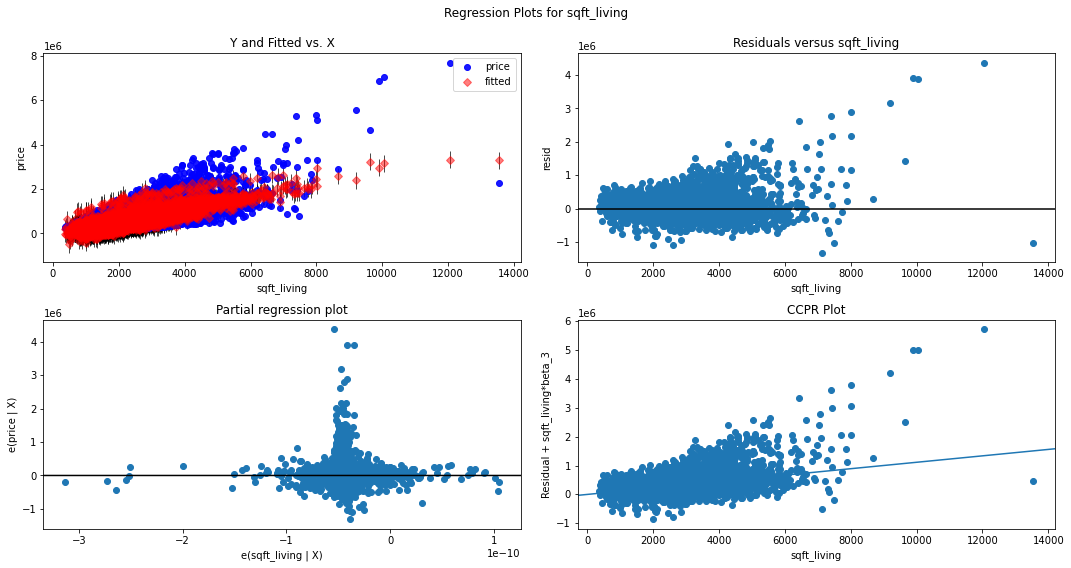

In [8]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_living', fig=fig);

In [24]:
# Normalizing distribution using log transformation

df['price_log'] = np.log(df['price'])
df['sqft_living_log'] = np.log(df['sqft_living'])

f = 'price_log~sqft_living_log'
model = ols(f, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.805e+04
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:19:50   Log-Likelihood:                -10231.
No. Observations:               21597   AIC:                         2.047e+04
Df Residuals:                   21595   BIC:                         2.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7234      0.047    142.612      0.000       6.631       6.816
sqft_living_log     0.8376      0.006    134.368      0.000       0.825       0.850
==============================================================================
Omnibus:                      123.577   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.096
Skew:                           0.143   Prob(JB):                     1.68e-25
Kurtosis:                       2.787   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# OLS between 'price_log' and 'sqft_living_log'

f = 'price_log~sqft_living_log'
model = ols(f, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.805e+04
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:19:50   Log-Likelihood:                -10231.
No. Observations:               21597   AIC:                         2.047e+04
Df Residuals:                   21595   BIC:                         2.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7234      0.047    142.612      0.000       6.631       6.816
sqft_living_log     0.8376      0.006    134.368      0.000       0.825       0.850
==============================================================================
Omnibus:                      123.577   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.096
Skew:                           0.143   Prob(JB):                     1.68e-25
Kurtosis:                       2.787   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

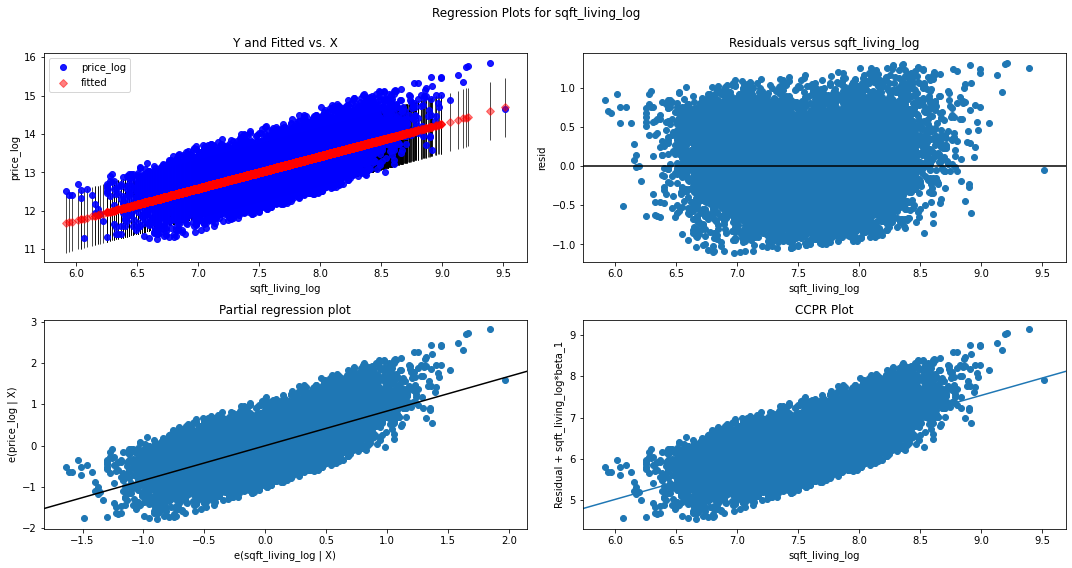

In [22]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_living_log', fig=fig);

| When 'price' and 'sqft_living' undergo log transformation, they are more normally distributed and more homoscedastic, making them better for modeling.

## Predictive Modeling

In [26]:
X = df[['sqft_living_log']]
y = df[['price_log']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [43]:
baseline = DummyRegressor()
baseline.fit(X_train, y_train)
print('baseline training score:', baseline.score(X_train, y_train))
print('baseline test score:', baseline.score(X_test, y_test))

baseline training score: 0.0
baseline test score: -0.001115408716650279


In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('first training score:', lr.score(X_train, y_train))
print('first test score', lr.score(X_test, y_test))

first training score: 0.45304017920923356
first test score 0.46158458240115385


## Conclusions